In [ ]:
!pip install --upgrade datasets

import seaborn as sns
import json
import math
import pandas as pd
import numpy as np
import pandas as pd
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from huggingface_hub import login
from datasets import Dataset, DatasetDict, load_dataset
from scipy import stats

JUDGE ONLY CONTEXT VARIATION CHANGE

In [ ]:
dataset = load_dataset("Ramitha/unique-records-snippet-combination-all")
df = pd.DataFrame(dataset['rawcases'])
df = df.drop(["ILRAlign_with_problem_context_only_llama", "ILRAlign_with_problem_context_only_falcon", "ILRAlign_with_problem_context_only_gemma", "ILRAlign_with_problem_context_only_mistral"], axis=1)

In [ ]:
model_cols = [
    "ILRAlign_llama",
    "ILRAlign_falcon",
    "ILRAlign_gemma",
    "ILRAlign_mistral"
]
df_sub = df[["dataset", "snippet_percentage", "gold_standard_cos"] + model_cols]
df_long = df_sub.melt(
    id_vars=["dataset", "snippet_percentage", "gold_standard_cos"],
    value_vars=model_cols,
    var_name="base_model",
    value_name="ILRAlign_score"
)

df_long["base_model"] = df_long["base_model"].str.replace("ILRAlign_", "")

def compute_corr(group):
    return pd.Series({
        "correlation": group["ILRAlign_score"].corr(group["gold_standard_cos"])
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "snippet_percentage"])
    .apply(compute_corr)
    .reset_index()
)

pivot_table = corr_table.pivot_table(
    index=["base_model", "snippet_percentage"],
    columns="dataset",
    values="correlation"
).sort_index(level=["base_model", "snippet_percentage"]).round(4)

In [ ]:
pivot_table

dataset                          alqa  newsqa      sl
base_model snippet_percentage                        
falcon     0                   0.7631  0.7034  0.7201
           25                  0.7476  0.8144  0.7605
           50                  0.7246  0.8293  0.7576
           75                  0.8282  0.8127  0.7821
           100                 0.8236  0.8086  0.7767
gemma      0                   0.7606  0.3875  0.6135
           25                  0.7201  0.3921  0.6239
           50                  0.7019  0.3740  0.6347
           75                  0.7357  0.3830  0.6445
           100                 0.7536  0.3765  0.6590
llama      0                   0.9186  0.8541  0.9070
           25                  0.9237  0.8689  0.8924
           50                  0.9293  0.8983  0.9121
           75                  0.9332  0.8932  0.9080
           100                 0.9294  0.8959  0.8995
mistral    0                   0.7630  0.7377  0.7851
           25                  0.8032  0.7774  0.8473
           50                  0.8109  0.7933  0.8550
           75                  0.8285  0.7773  0.8579
           100                 0.8256  0.7946  0.8646

In [ ]:
mean_corr_table = pivot_table.groupby("snippet_percentage").mean().round(4)

In [ ]:
mean_corr_table

dataset,alqa,newsqa,sl
snippet_percentage,,,
0,0.8013,0.6707,0.7564
25,0.7986,0.7132,0.7810
50,0.7917,0.7237,0.7899
75,0.8314,0.7166,0.7981
100,0.8330,0.7189,0.7999


In [ ]:
def compute_corr_with_n(group):
    return pd.Series({
        "correlation": group["ILRAlign_score"].corr(group["gold_standard_cos"]),
        "n": len(group)
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "snippet_percentage"])
    .apply(compute_corr_with_n)
    .reset_index()
)

df_0 = corr_table[corr_table["snippet_percentage"] == 0].copy()
df_0 = df_0.rename(columns={"correlation": "correlation_0", "n": "n_0"})

def fisher_z(r):
    return np.arctanh(r)

def test_significance(r0, rX, n0, nX):
    if abs(r0) >= 1 or abs(rX) >= 1:
        return False
    z0 = fisher_z(r0)
    zX = fisher_z(rX)
    se = np.sqrt(1 / (n0 - 3) + 1 / (nX - 3))
    z = (z0 - zX) / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return p < 0.05

result_frames = []
for perc in [25, 50, 75, 100]:
    df_x = corr_table[corr_table["snippet_percentage"] == perc].copy()
    df_x = df_x.rename(columns={"correlation": "correlation_x", "n": "n_x"})
    merged = pd.merge(df_0, df_x, on=["base_model", "dataset"])
    merged[f"significant_{perc}"] = merged.apply(
        lambda row: test_significance(
            row["correlation_0"], row["correlation_x"],
            row["n_0"], row["n_x"]
        ),
        axis=1
    )
    result_frames.append(
        merged[["base_model", "dataset", f"significant_{perc}"]]
    )

from functools import reduce
final = reduce(
    lambda left, right: pd.merge(left, right, on=["base_model", "dataset"]),
    result_frames
)

final.columns = ["base_model", "dataset", "25", "50", "75", "100"]
final = final[["base_model", "dataset", "25", "50", "75", "100"]]
final

/tmp/ipython-input-1846148079.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_corr_with_n)


,base_model,dataset,25,50,75,100
0,falcon,alqa,False,True,True,True
1,gemma,alqa,True,True,False,False
2,llama,alqa,False,True,True,True
3,mistral,alqa,True,True,True,True
4,falcon,newsqa,True,True,True,True
5,gemma,newsqa,False,False,False,False
6,llama,newsqa,False,True,True,True
7,mistral,newsqa,True,True,True,True
8,falcon,sl,True,True,True,True
9,gemma,sl,False,False,False,True


FULL PIPELINE CONTEXT VARIATION CHANGE

In [ ]:
dataset = load_dataset("Ramitha/full-pipeline-context-results-all")
df = pd.DataFrame(dataset['rawcases'])

In [ ]:
model_cols = [
    "ILRAlign_llama",
    "ILRAlign_falcon",
    "ILRAlign_gemma",
    "ILRAlign_mistral"
]
df_sub = df[["dataset", "snippet_percentage", "gold_standard_cos"] + model_cols]
df_long = df_sub.melt(
    id_vars=["dataset", "snippet_percentage", "gold_standard_cos"],
    value_vars=model_cols,
    var_name="base_model",
    value_name="ILRAlign_score"
)

df_long["base_model"] = df_long["base_model"].str.replace("ILRAlign_", "")

def compute_corr(group):
    return pd.Series({
        "correlation": group["ILRAlign_score"].corr(group["gold_standard_cos"])
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "snippet_percentage"])
    .apply(compute_corr)
    .reset_index()
)

pivot_table = corr_table.pivot_table(
    index=["base_model", "snippet_percentage"],
    columns="dataset",
    values="correlation"
).sort_index(level=["base_model", "snippet_percentage"]).round(4)

/tmp/ipython-input-594563183.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_corr)


In [ ]:
pivot_table

dataset                          alqa  newsqa      sl
base_model snippet_percentage                        
falcon     0                   0.8897  0.0805  0.1238
           25                  0.8279  0.8025  0.8389
           50                  0.8984  0.8360  0.8036
           75                  0.1206  0.8107  0.8251
           100                 0.8236  0.8086  0.7767
gemma      0                   0.2331  0.0149  0.1405
           25                  0.6888  0.0995  0.6235
           50                  0.7072  0.0987  0.6779
           75                  0.6761  0.1137  0.6700
           100                 0.7536  0.3765  0.6590
llama      0                   0.8978  0.8134  0.8677
           25                  0.8981  0.8617  0.9086
           50                  0.9118  0.8835  0.9180
           75                  0.9287  0.8994  0.9046
           100                 0.9294  0.8959  0.8995
mistral    0                   0.5637  0.7110  0.6361
           25                  0.7957  0.7426  0.8136
           50                  0.8193  0.7841  0.8039
           75                  0.7962  0.7619  0.8324
           100                 0.8256  0.7946  0.8646

In [ ]:
mean_corr_table = pivot_table.groupby("snippet_percentage").mean().round(4)

In [ ]:
mean_corr_table

dataset,alqa,newsqa,sl
snippet_percentage,,,
0,0.6461,0.4050,0.4420
25,0.8026,0.6266,0.7962
50,0.8342,0.6506,0.8008
75,0.6304,0.6464,0.8080
100,0.8330,0.7189,0.7999


In [ ]:
def compute_corr_with_n(group):
    return pd.Series({
        "correlation": group["ILRAlign_score"].corr(group["gold_standard_cos"]),
        "n": len(group)
    })

corr_table = (
    df_long.groupby(["dataset", "base_model", "snippet_percentage"])
    .apply(compute_corr_with_n)
    .reset_index()
)

df_0 = corr_table[corr_table["snippet_percentage"] == 0].copy()
df_0 = df_0.rename(columns={"correlation": "correlation_0", "n": "n_0"})

def fisher_z(r):
    return np.arctanh(r)

def test_significance(r0, rX, n0, nX):
    if abs(r0) >= 1 or abs(rX) >= 1:
        return False
    z0 = fisher_z(r0)
    zX = fisher_z(rX)
    se = np.sqrt(1 / (n0 - 3) + 1 / (nX - 3))
    z = (z0 - zX) / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return p < 0.05

result_frames = []
for perc in [25, 50, 75, 100]:
    df_x = corr_table[corr_table["snippet_percentage"] == perc].copy()
    df_x = df_x.rename(columns={"correlation": "correlation_x", "n": "n_x"})
    merged = pd.merge(df_0, df_x, on=["base_model", "dataset"])
    merged[f"significant_{perc}"] = merged.apply(
        lambda row: test_significance(
            row["correlation_0"], row["correlation_x"],
            row["n_0"], row["n_x"]
        ),
        axis=1
    )
    result_frames.append(
        merged[["base_model", "dataset", f"significant_{perc}"]]
    )

from functools import reduce
final = reduce(
    lambda left, right: pd.merge(left, right, on=["base_model", "dataset"]),
    result_frames
)

final.columns = ["base_model", "dataset", "25", "50", "75", "100"]
final = final[["base_model", "dataset", "25", "50", "75", "100"]]
final

/tmp/ipython-input-362389157.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_corr_with_n)


,base_model,dataset,25,50,75,100
0,falcon,alqa,True,False,True,True
1,gemma,alqa,True,True,True,True
2,llama,alqa,False,True,True,True
3,mistral,alqa,True,True,True,True
4,falcon,newsqa,True,True,True,True
5,gemma,newsqa,True,True,True,True
6,llama,newsqa,True,True,True,True
7,mistral,newsqa,False,True,True,True
8,falcon,sl,True,True,True,True
9,gemma,sl,True,True,True,True


TEMP BREAK EXPERIMENTS

In [ ]:
dataset1 = load_dataset("Ramitha/unique-records-snippet-combination-all")
df1 = pd.DataFrame(dataset1["rawcases"])
df1 = df1.rename(columns={"ILRAlign_llama": "ILRAlign_judge_only_llama", "ILRAlign_falcon": "ILRAlign_judge_only_falcon",
                                "ILRAlign_gemma": "ILRAlign_judge_only_gemma", "ILRAlign_mistral": "ILRAlign_judge_only_mistral"})
dataset2 = load_dataset("Ramitha/full-pipeline-context-results-all")
df2 = pd.DataFrame(dataset2["rawcases"])
df2 = df2.rename(columns={"ILRAlign_llama": "ILRAlign_full_pipeline_llama", "ILRAlign_falcon": "ILRAlign_full_pipeline_falcon",
                                "ILRAlign_gemma": "ILRAlign_full_pipeline_gemma", "ILRAlign_mistral": "ILRAlign_full_pipeline_mistral"})

README.md: 0.00B [00:00, ?B/s]

data/rawcases-00000-of-00001.parquet:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

Generating rawcases split:   0%|          | 0/24000 [00:00<?, ? examples/s]

/tmp/ipython-input-2929072060.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(assign_temp_bin)


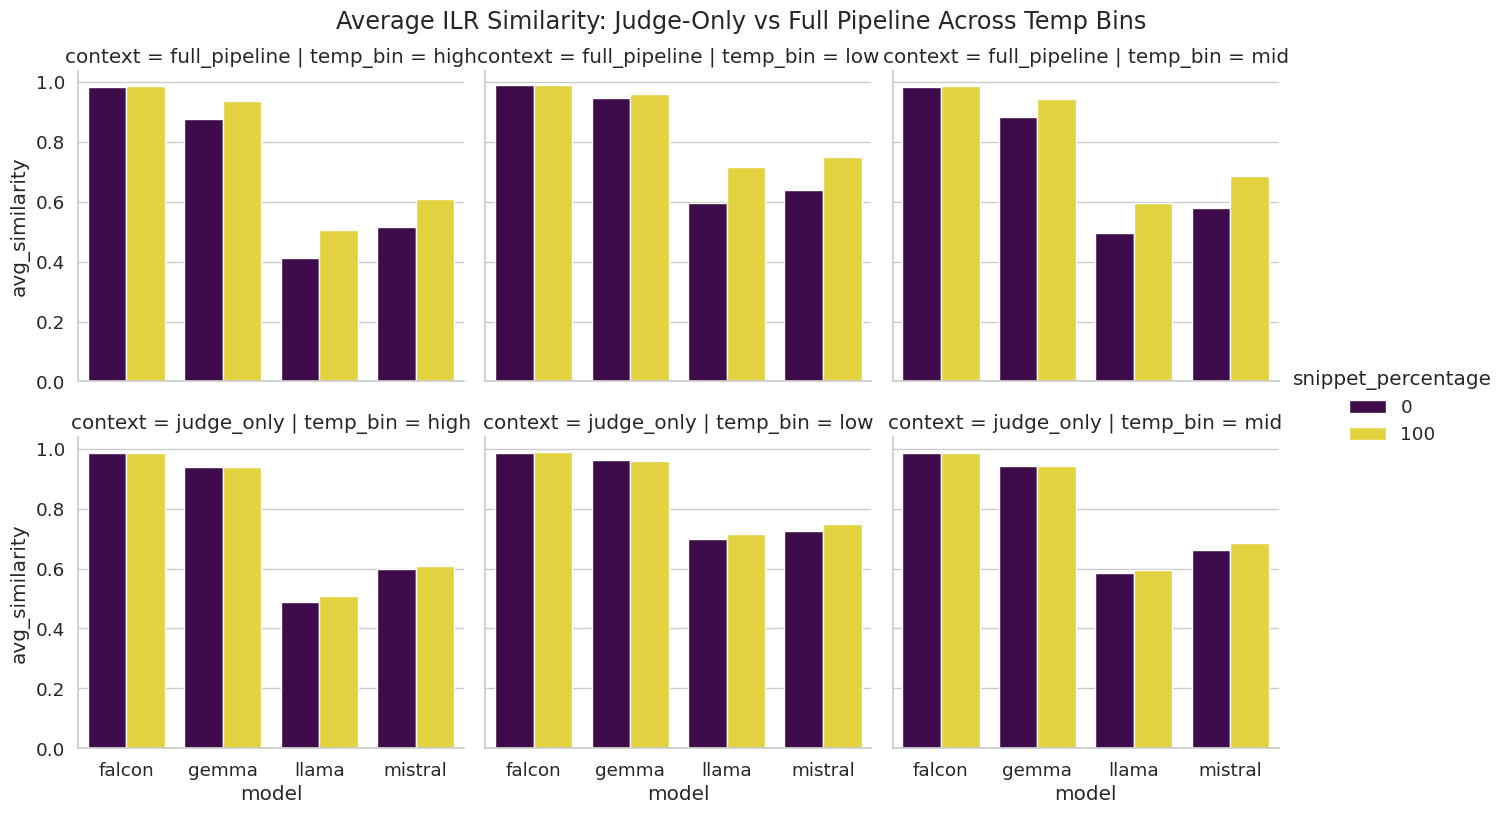

In [ ]:
df_j = df1.copy()
df_f = df2.copy()

df_j = df_j[df_j["snippet_percentage"].isin([0, 100])]
df_f = df_f[df_f["snippet_percentage"].isin([0, 100])]

judge_cols = [
    "ILRAlign_judge_only_llama",
    "ILRAlign_judge_only_falcon",
    "ILRAlign_judge_only_gemma",
    "ILRAlign_judge_only_mistral"
]

full_cols = [
    "ILRAlign_full_pipeline_llama",
    "ILRAlign_full_pipeline_falcon",
    "ILRAlign_full_pipeline_gemma",
    "ILRAlign_full_pipeline_mistral"
]

df_j_long = df_j.melt(
    id_vars=["temperature", "snippet_percentage", "model"],
    value_vars=judge_cols,
    var_name="judge_model",
    value_name="score"
).dropna(subset=["score"])
df_j_long["context"] = "judge_only"

df_f_long = df_f.melt(
    id_vars=["temperature", "snippet_percentage", "model"],
    value_vars=full_cols,
    var_name="judge_model",
    value_name="score"
).dropna(subset=["score"])
df_f_long["context"] = "full_pipeline"

df_long = pd.concat([df_j_long, df_f_long], ignore_index=True)

def assign_temp_bin(subdf):
    temps = subdf["temperature"]
    q_low = temps.quantile(1/3)
    q_high = temps.quantile(2/3)
    def f(t):
        if t <= q_low: return "low"
        if t <= q_high: return "mid"
        return "high"
    return subdf["temperature"].apply(f)

df_long["temp_bin"] = (
    df_long
    .groupby(["model", "context"])
    .apply(assign_temp_bin)
    .reset_index(level=[0,1], drop=True)
)

avg = (
    df_long
    .groupby(["context", "model", "snippet_percentage", "temp_bin"])
    .agg(avg_similarity=("score", "mean"))
    .reset_index()
)

sns.set(style="whitegrid", font_scale=1.2)

g = sns.catplot(
    data=avg,
    x="model",
    y="avg_similarity",
    hue="snippet_percentage",
    col="temp_bin",
    row="context",
    kind="bar",
    height=4,
    aspect=1.1,
    palette="viridis"
)

g.fig.suptitle("Average ILR Similarity: Judge-Only vs Full Pipeline Across Temp Bins", y=1.02)
plt.show()


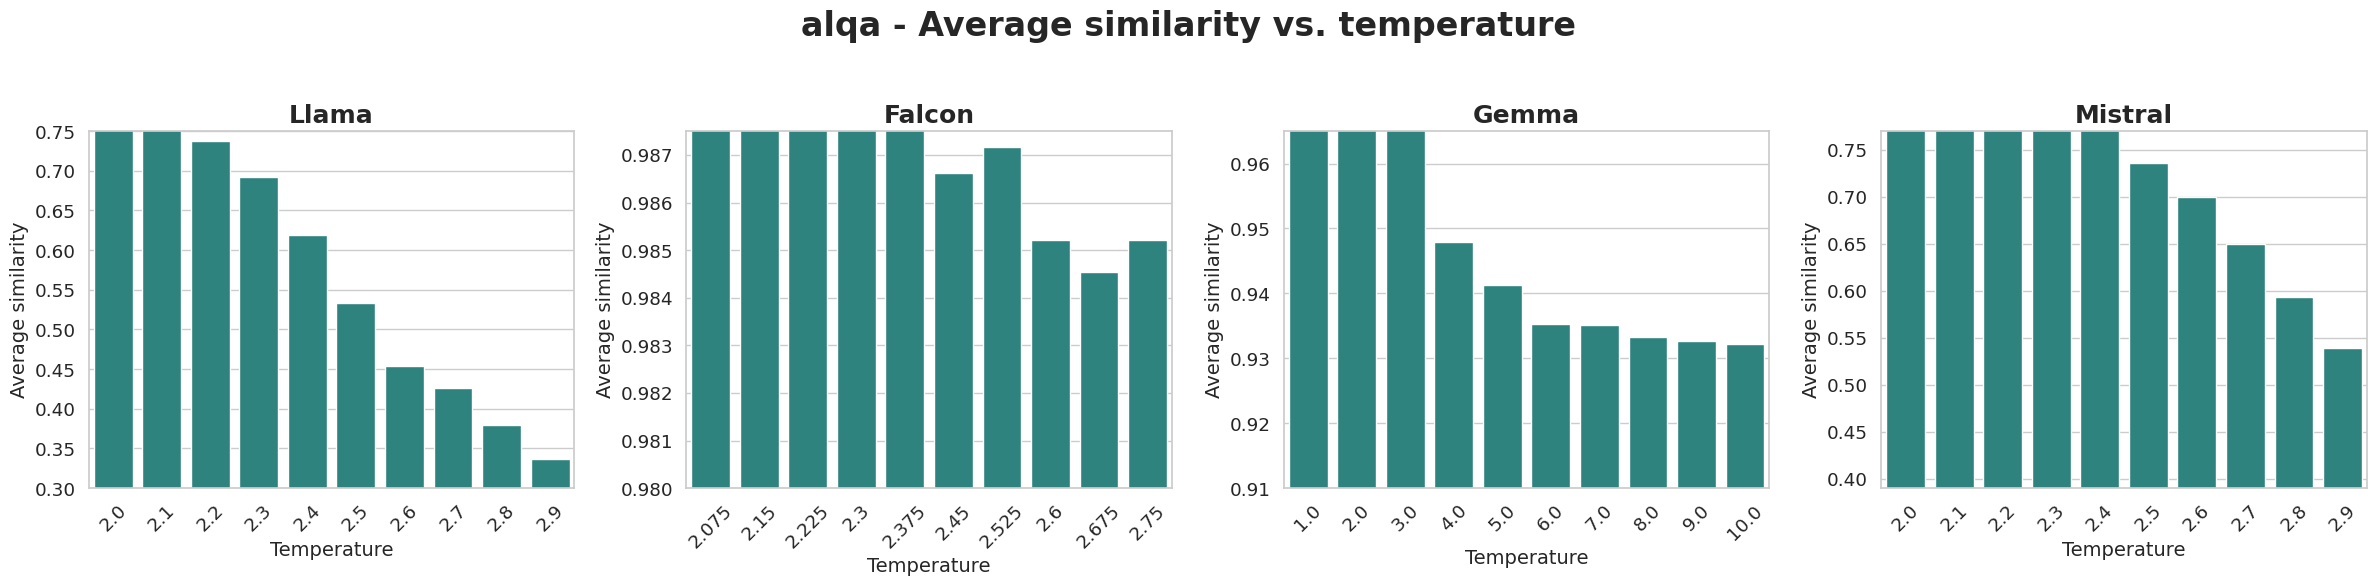

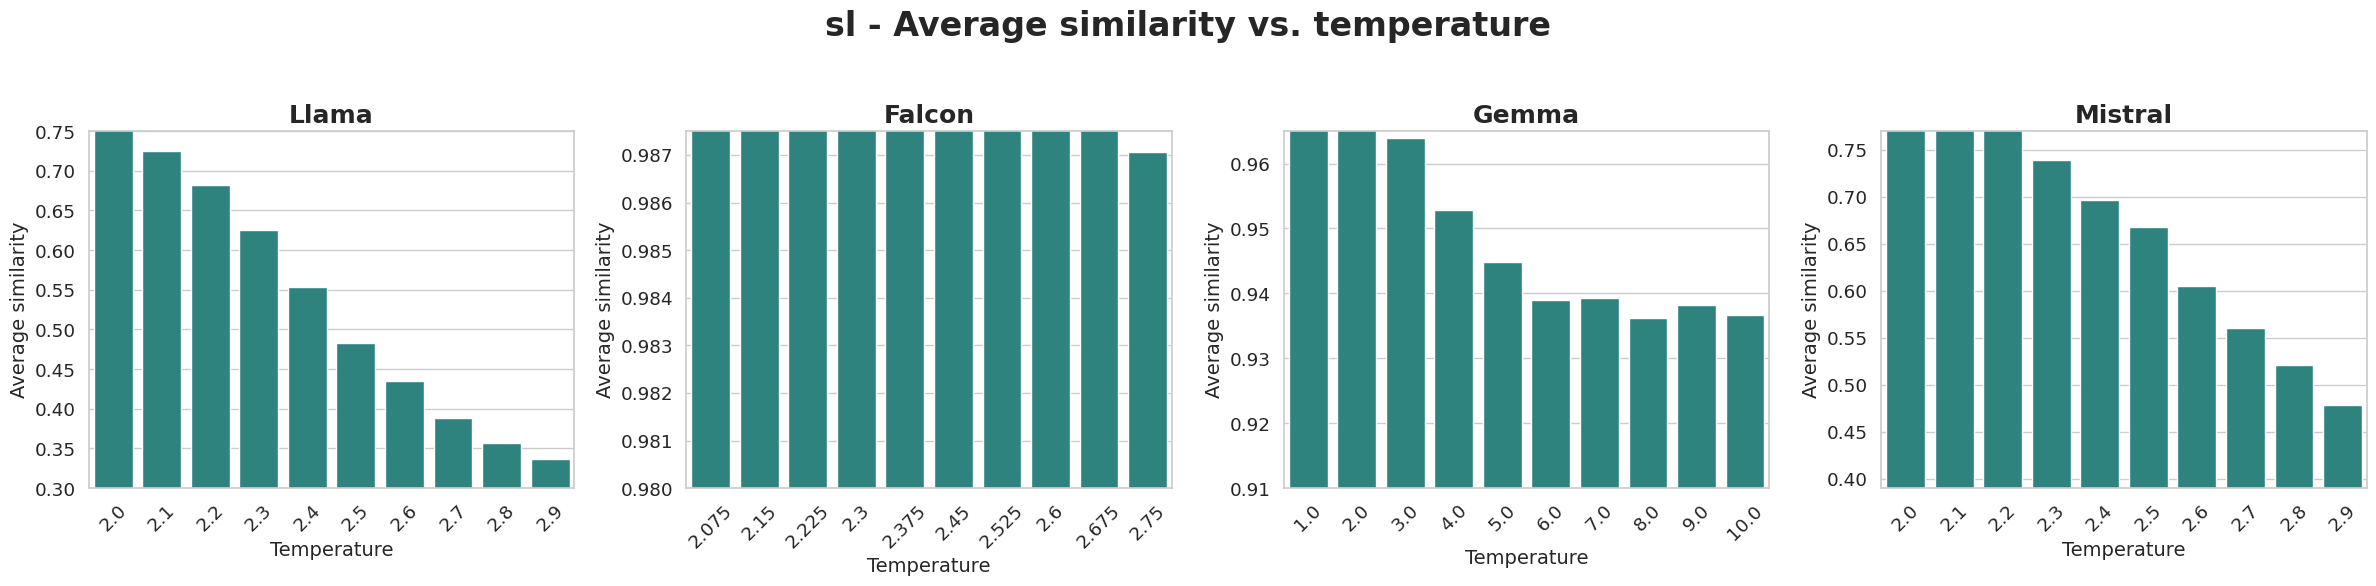

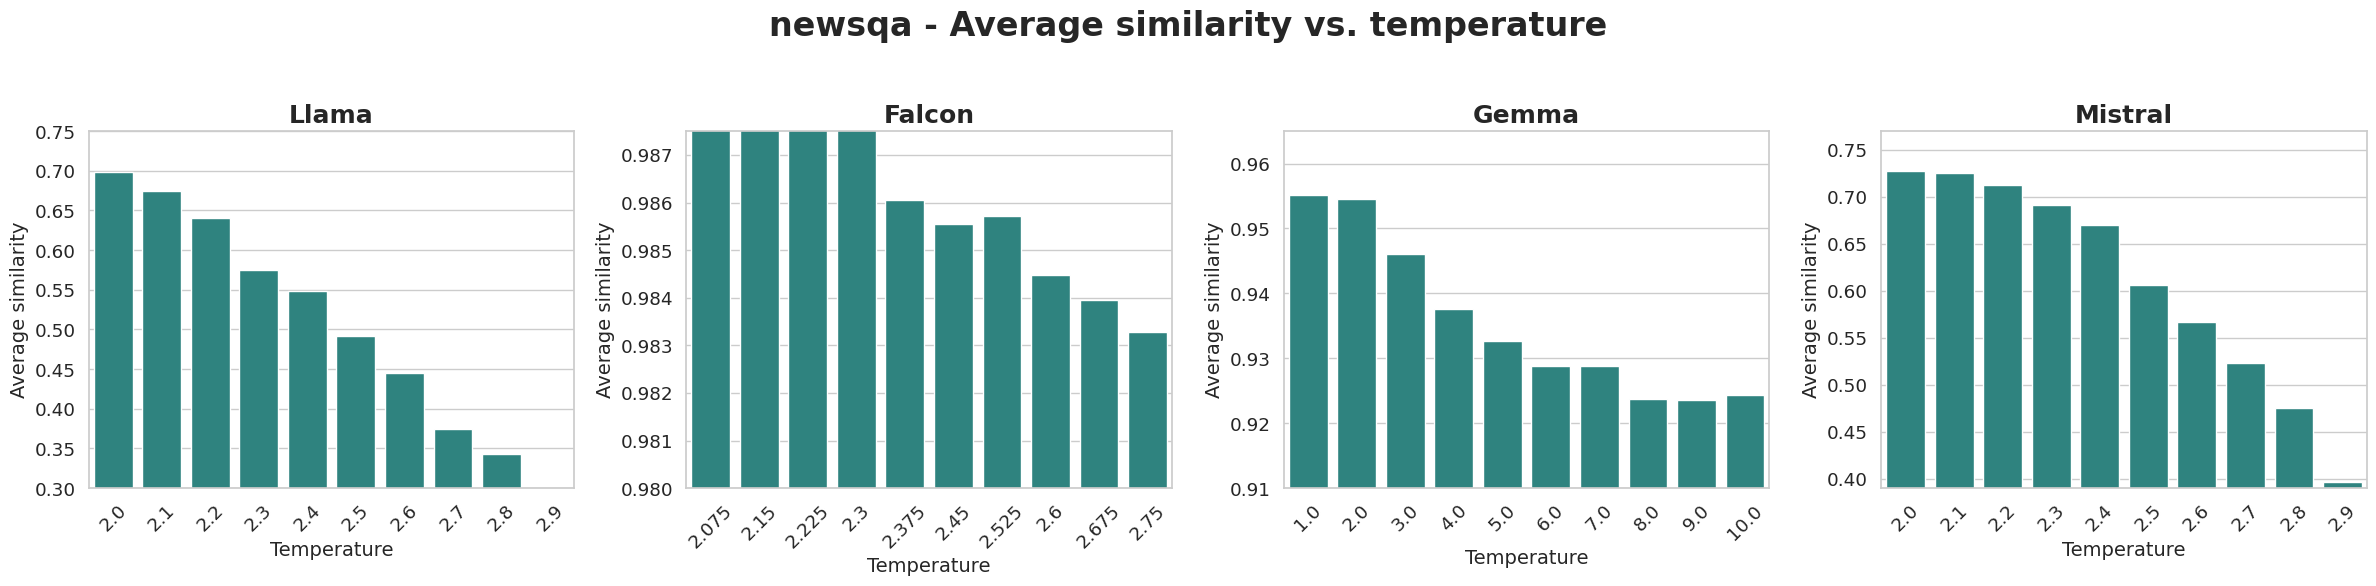

In [ ]:
def plot_model_scores(df, model_name, ax, y1, y2):
    df_model = df[df['model'].str.contains(model_name, case=False, na=False)]
    grouped_df = (
        df_model.groupby('temperature', as_index=False)['gold_standard_cos']
        .mean()
    )
    sns.barplot(
        x='temperature',
        y='gold_standard_cos',
        data=grouped_df,
        color=sns.color_palette('viridis', 1)[0],
        ax=ax
    )
    ax.set_title(f'{model_name}', fontsize=18, weight='bold')
    ax.set_ylabel('Average similarity', fontsize=14)
    ax.set_xlabel('Temperature', fontsize=14)
    ax.set_ylim(y1, y2)
    ax.tick_params(axis='x', rotation=45)
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

datasets = df2['dataset'].unique()
for dataset in datasets:
    df_dataset = df2[df2['dataset'] == dataset]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=False)
    fig.suptitle(f'{dataset} - Average similarity vs. temperature', fontsize=24, weight='bold')
    plot_model_scores(df_dataset, 'Llama', axes[0],  0.3, 0.75)
    plot_model_scores(df_dataset, 'Falcon', axes[1], 0.9800, 0.9875)
    plot_model_scores(df_dataset, 'Gemma', axes[2],0.91, 0.965)
    plot_model_scores(df_dataset, 'Mistral', axes[3], 0.39, 0.77)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
